Column mapping:
  X_COL      -> Usage Rate
  Y_COL      -> SCA
  SIZE_COL   -> G+A
  STATE_COL  -> State
  PLAYER_COL -> Name


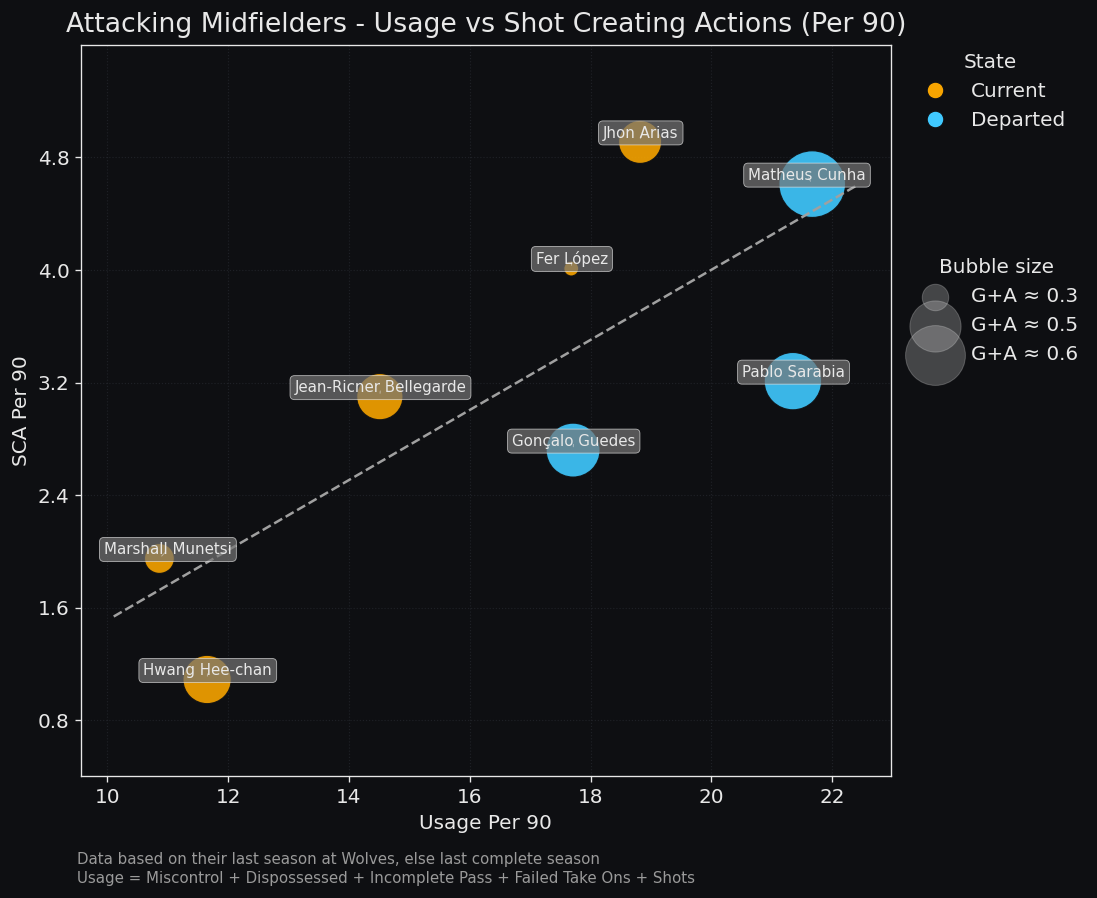

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# pip install adjustText
try:
    from adjustText import adjust_text
    _USE_ADJUST_TEXT = True
except Exception:
    _USE_ADJUST_TEXT = False

FILE  = "project3-2.xlsx"
SHEET = "FINAL"

LOGICAL_COLS = {
    "X_COL": ["usage rate", "usage", "usg", "usg%"],
    "Y_COL": ["sca", "shot creating actions", "shot-creating actions"],
    "SIZE_COL": ["g+a", "ga", "goals + assists", "goals and assists"],
    "STATE_COL": ["state", "status", "roster state"],
    "PLAYER_COL": ["player", "player name", "name"]
}

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
CURR_COLOR = "#f7a400"
DEPT_COLOR = "#40c9ff"
REG_LINE_COLOR = "#a0a0a0"

SIZE_MIN, SIZE_MAX = 80, 1600

TITLE = "Attacking Midfielders - Usage vs Shot Creating Actions (Per 90)"
FOOTNOTE = "Data based on their last season at Wolves, else last complete season"
FOOTNOTE2 = "Usage = Miscontrol + Dispossessed + Incomplete Pass + Failed Take Ons + Shots"

#helpers
def _norm(s: str) -> str:
    """Normalize header names to compare flexibly."""
    s = str(s)
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    """
    Try to find a column in df whose normalized name matches any in candidates
    (also matches if the candidate is a substring of the normalized header).
    """
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())

    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]

    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]

    if required:
        raise KeyError(
            f"Could not resolve a column for candidates {candidates}. "
            f"Available columns: {list(df.columns)}"
        )
    return None

#cols
if not os.path.exists(FILE):
    raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

df = pd.read_excel(FILE, sheet_name=SHEET)

resolved = {}
for logical, cands in LOGICAL_COLS.items():
    resolved[logical] = resolve_column(df, cands, required=True)

X_COL      = resolved["X_COL"]
Y_COL      = resolved["Y_COL"]
SIZE_COL   = resolved["SIZE_COL"]
STATE_COL  = resolved["STATE_COL"]
PLAYER_COL = resolved["PLAYER_COL"]

print("Column mapping:")
for k, v in resolved.items():
    print(f"  {k:<10} -> {v}")

#clean
for c in [X_COL, Y_COL, SIZE_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

data = df.dropna(subset=[X_COL, Y_COL, SIZE_COL, STATE_COL, PLAYER_COL]).copy()

def _std_state(s):
    s = str(s).strip().lower()
    if s in {"current", "active", "on roster", "present"}:
        return "Current"
    if s in {"departed", "left", "sold", "loaned", "released", "former"}:
        return "Departed"
    return s.title()

data[STATE_COL] = data[STATE_COL].apply(_std_state)

gmin, gmax = data[SIZE_COL].min(), data[SIZE_COL].max()
if np.isclose(gmin, gmax):
    sizes = np.full(len(data), (SIZE_MIN + SIZE_MAX) / 2.0)
else:
    norm = (data[SIZE_COL] - gmin) / (gmax - gmin)
    sizes = SIZE_MIN + norm * (SIZE_MAX - SIZE_MIN)

state_to_color = {
    "Current": CURR_COLOR,
    "Departed": DEPT_COLOR
}
colors = data[STATE_COL].map(state_to_color).fillna(FG_COLOR)

#lin reg
x = data[X_COL].values
y = data[Y_COL].values
if len(x) >= 2 and np.isfinite(x).all() and np.isfinite(y).all():
    m, b = np.polyfit(x, y, 1)
    y_pred = m * x + b
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
else:
    m = b = r2 = np.nan

#figure
plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": BG_COLOR,
    "axes.facecolor": BG_COLOR,
    "axes.edgecolor": FG_COLOR,
    "axes.labelcolor": FG_COLOR,
    "xtick.color": FG_COLOR,
    "ytick.color": FG_COLOR,
    "text.color": FG_COLOR,
    "grid.color": GRID_COLOR,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

sc = ax.scatter(
    data[X_COL], data[Y_COL],
    s=sizes,
    c=colors,
    edgecolors=BG_COLOR,
    linewidths=0.7,
    alpha=0.9
)

#player labels
texts = []
for _, row in data.iterrows():
    texts.append(
        ax.text(
            row[X_COL], row[Y_COL],
            str(row[PLAYER_COL]),
            fontsize=9,
            ha="center", va="bottom",
            clip_on=True,
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='#757575',
                alpha=0.7,
                edgecolor=FG_COLOR,
                linewidth=0.5
            )
        )
    )

if _USE_ADJUST_TEXT and len(texts) > 0:
    adjust_text(
        texts,
        only_move={'points': 'y', 'text': 'xy'},
        arrowprops=dict(arrowstyle="-", lw=0.6, color=FG_COLOR, alpha=0.5),
        ax=ax,
        expand_points=(1.1, 1.2),
        expand_text=(1.1, 1.2),
        force_points=0.2,
        force_text=0.2,
        lim=500
    )

#reg
if np.isfinite(m) and np.isfinite(b):
    x_min, x_max = data[X_COL].min(), data[X_COL].max()
    pad_x = (x_max - x_min) * 0.07 if x_max > x_min else 1.0
    x_line = np.linspace(x_min - pad_x, x_max + pad_x, 200)
    y_line = m * x_line + b
    ax.plot(
        x_line, y_line, linestyle="--", linewidth=1.5, color=REG_LINE_COLOR,
        label=f"Linear fit: y = {m:.2f}x + {b:.2f} (R²={r2:.2f})"
    )

x_min, x_max = data[X_COL].min(), data[X_COL].max()
y_min, y_max = data[Y_COL].min(), data[Y_COL].max()

x_pad = (x_max - x_min) * 0.12 if x_max > x_min else 1.0
y_pad = (y_max - y_min) * 0.18 if y_max > y_min else 1.0

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)

ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))

ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

#title
ax.set_title(TITLE, fontsize=16, pad=8)
ax.set_xlabel("Usage Per 90")
ax.set_ylabel("SCA Per 90")
ax.set_axisbelow(True)

#legend
state_labels = sorted(set(["Current", "Departed"]) & set(data[STATE_COL].unique()))
state_handles = []
for label in state_labels:
    color = state_to_color.get(label, FG_COLOR)
    state_handles.append(
        Line2D([0], [0], marker="o", color="none",
               markerfacecolor=color, markeredgecolor=BG_COLOR,
               markeredgewidth=0.7, markersize=10, label=label)
    )

if len(data) >= 3 and not np.isnan(gmin) and not np.isnan(gmax) and not np.isclose(gmin, gmax):
    q_vals = np.unique(np.round(np.quantile(data[SIZE_COL], [0.15, 0.5, 0.85]), 1))
else:
    q_vals = np.array([gmin]) if not np.isnan(gmin) else np.array([])

size_handles = []
for q in q_vals:
    if np.isclose(gmin, gmax):
        s = (SIZE_MIN + SIZE_MAX) / 2.0
    else:
        s = SIZE_MIN + (q - gmin) / (gmax - gmin) * (SIZE_MAX - SIZE_MIN)
    size_handles.append(
        plt.scatter([], [], s=s, c=FG_COLOR, alpha=0.25,
                    edgecolors=FG_COLOR, linewidths=0.6,
                    label=f"G+A ≈ {q:g}")
    )

if state_handles:
    leg1 = ax.legend(handles=state_handles, title="State",
                     loc="upper left", bbox_to_anchor=(1.02, 1.0),
                     frameon=False, borderaxespad=0.0)
    ax.add_artist(leg1)

if size_handles:
    ax.legend(handles=size_handles, title="Bubble size",
              loc="upper left", bbox_to_anchor=(1.02, 0.72),
              frameon=False, borderaxespad=0.0)

fig.text(0.12, 0.03, FOOTNOTE, color="#9a9a9a", fontsize=9)
fig.text(0.12, 0.01, FOOTNOTE2, color="#9a9a9a", fontsize=9)


plt.tight_layout(rect=[0.06, 0.04, 0.84, 0.94])

plt.show()


Column mapping:
  SCA_COL    -> SCA
  USAGE_COL  -> Usage Rate
  STATE_COL  -> State
  PLAYER_COL -> Name
  GA_COL     -> G+A


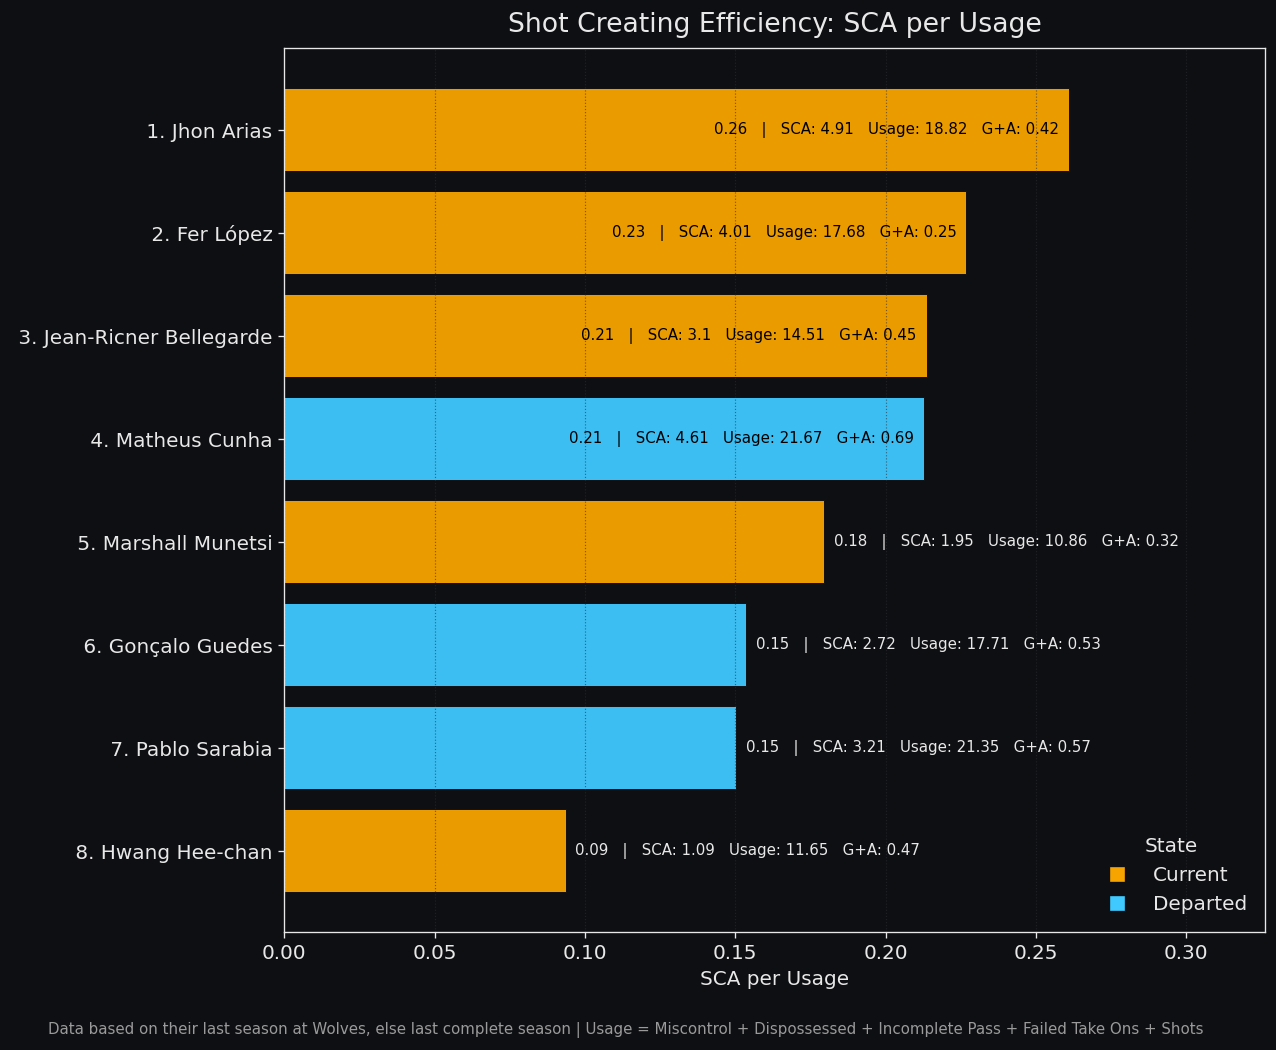

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

FILE  = "project3-2.xlsx"
SHEET = "FINAL"

LOGICAL_COLS = {
    "SCA_COL":    ["sca", "shot creating actions", "shot-creating actions"],
    "USAGE_COL":  ["usage rate", "usage", "usg", "usg%"],
    "STATE_COL":  ["state", "status", "roster state"],
    "PLAYER_COL": ["player", "player name", "name"],
    "GA_COL":     ["g+a", "ga", "goals + assists", "goals and assists"],
}

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
CURR_COLOR = "#f7a400"
DEPT_COLOR = "#40c9ff"

TITLE = "Shot Creating Efficiency: SCA per Usage"
FOOTNOTE = "Data based on their last season at Wolves, else last complete season | Usage = Miscontrol + Dispossessed + Incomplete Pass + Failed Take Ons + Shots"

#helpers
def _norm(s: str) -> str:
    s = str(s)
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())
    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]
    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]
    if required:
        raise KeyError(
            f"Could not resolve a column for candidates {candidates}. "
            f"Available columns: {list(df.columns)}"
        )
    return None

def fmt_float(x, nd=2):
    if x is None or not np.isfinite(x):
        return ""
    s = f"{x:.{nd}f}"
    s = s.rstrip("0").rstrip(".")
    return s

#load
if not os.path.exists(FILE):
    raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

df = pd.read_excel(FILE, sheet_name=SHEET)

resolved = {}
for logical, cands in LOGICAL_COLS.items():
    resolved[logical] = resolve_column(df, cands, required=(logical not in ["GA_COL"]))

SCA_COL    = resolved["SCA_COL"]
USAGE_COL  = resolved["USAGE_COL"]
STATE_COL  = resolved["STATE_COL"]
PLAYER_COL = resolved["PLAYER_COL"]
GA_COL     = resolved.get("GA_COL")

print("Column mapping:")
for k, v in resolved.items():
    if v is not None:
        print(f"  {k:<10} -> {v}")

#clean
work = df.copy()

work[SCA_COL]   = pd.to_numeric(work[SCA_COL], errors="coerce")
work[USAGE_COL] = pd.to_numeric(work[USAGE_COL], errors="coerce")
if GA_COL:
    work[GA_COL] = pd.to_numeric(work[GA_COL], errors="coerce")

def _std_state(s):
    s = str(s).strip().lower()
    if s in {"current", "active", "on roster", "present"}:
        return "Current"
    if s in {"departed", "left", "sold", "loaned", "released", "former"}:
        return "Departed"
    return s.title()

work[STATE_COL] = work[STATE_COL].apply(_std_state)

work = work.dropna(subset=[SCA_COL, USAGE_COL, PLAYER_COL, STATE_COL])
work = work[work[USAGE_COL] > 0].copy()

work["SCAperUsage"] = work[SCA_COL] / work[USAGE_COL]
work["Rank"] = work["SCAperUsage"].rank(method="min", ascending=False).astype(int)
work = work.sort_values("SCAperUsage", ascending=True)

state_to_color = {"Current": CURR_COLOR, "Departed": DEPT_COLOR}
bar_colors = work[STATE_COL].map(state_to_color).fillna(FG_COLOR).values

# ---------- plot ----------
plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": BG_COLOR,
    "axes.facecolor": BG_COLOR,
    "axes.edgecolor": FG_COLOR,
    "axes.labelcolor": FG_COLOR,
    "xtick.color": FG_COLOR,
    "ytick.color": FG_COLOR,
    "text.color": FG_COLOR,
    "grid.color": GRID_COLOR,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(12, 10), dpi=120)

y_pos = np.arange(len(work))
bars = ax.barh(
    y_pos, work["SCAperUsage"].values,
    color=bar_colors, edgecolor="#0e0f12", linewidth=0.6, alpha=0.95
)

player_labels = []
for _, r in work.iterrows():
    prefix = f"{r['Rank']:>2d}. "
    player_labels.append(prefix + str(r[PLAYER_COL]))
ax.set_yticks(y_pos, labels=player_labels)

ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.6)

#titles
ax.set_title(TITLE, fontsize=16, pad=10)
ax.set_xlabel("SCA per Usage")

xmax = work["SCAperUsage"].max()
ax.set_xlim(0, xmax * 1.25 if np.isfinite(xmax) else 1.0)

fig.tight_layout(rect=[0.08, 0.08, 0.98, 0.93])
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

ax_bbox_disp = ax.get_window_extent(renderer)

def data_to_disp(x, y):
    return ax.transData.transform((x, y))

x0, x1 = ax.get_xlim()
pad = (x1 - x0) * 0.01

for bar, (_, r) in zip(bars, work.iterrows()):
    xval = bar.get_width()
    yval = bar.get_y() + bar.get_height() / 2.0

    sca_str    = fmt_float(r[SCA_COL])
    usage_str  = fmt_float(r[USAGE_COL])
    metric_str = fmt_float(r["SCAperUsage"])
    if GA_COL and pd.notna(r.get(GA_COL)):
        ga_str = fmt_float(r[GA_COL])
        label_text = f"{metric_str}   |   SCA: {sca_str}   Usage: {usage_str}   G+A: {ga_str}"
    else:
        label_text = f"{metric_str}   |   SCA: {sca_str}   Usage: {usage_str}"

    txt = ax.text(xval + pad, yval, label_text,
                  va="center", ha="left", fontsize=9, color=FG_COLOR,
                  zorder=5, clip_on=False)

    fig.canvas.draw()
    txt_bbox_disp = txt.get_window_extent(renderer)

    if txt_bbox_disp.x1 > ax_bbox_disp.x1:
        txt.set_x(xval - pad)
        txt.set_ha("right")
        txt.set_color("black")
        txt.set_clip_on(True)
        fig.canvas.draw()
        txt_bbox_disp = txt.get_window_extent(renderer)
        if txt_bbox_disp.x1 > ax_bbox_disp.x1:
            extra_pad = (x1 - x0) * 0.002
            txt.set_x(xval - pad - extra_pad)
            fig.canvas.draw()

#legend
state_labels_present = list(dict.fromkeys(work[STATE_COL].tolist()))
state_handles = []
for label in state_labels_present:
    color = state_to_color.get(label, FG_COLOR)
    state_handles.append(
        Line2D([0], [0], marker="s", color="none",
               markerfacecolor=color, markeredgecolor="#0e0f12",
               markeredgewidth=0.8, markersize=10, label=label)
    )

if state_handles:
    ax.legend(handles=state_handles, title="State",
              loc="lower right", frameon=False)

fig.text(0.12, 0.06, FOOTNOTE, color="#9a9a9a", fontsize=9)

plt.show()


Column mapping:
  X_COL      -> Usage Rate
  Y_COL      -> Value
  SIZE_COL   -> G+A
  STATE_COL  -> State
  PLAYER_COL -> Name


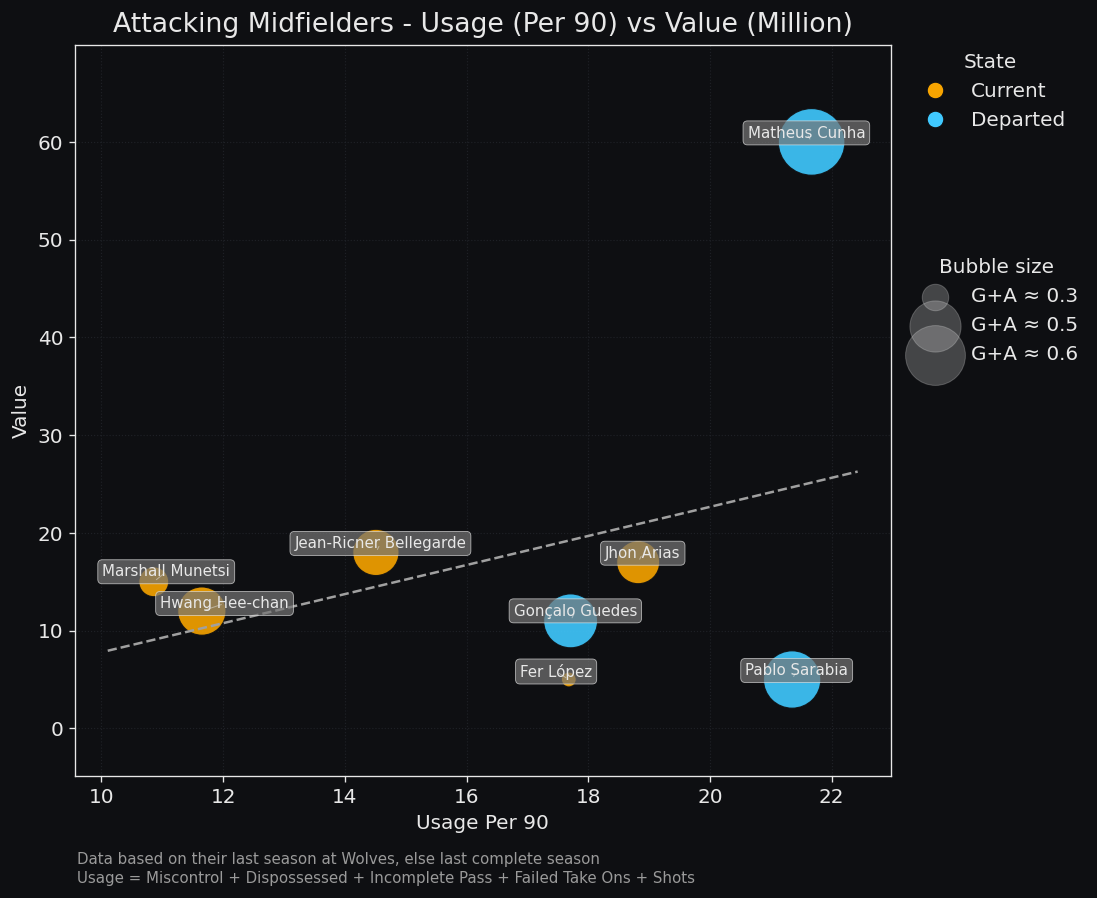

In [9]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# pip install adjustText
try:
    from adjustText import adjust_text
    _USE_ADJUST_TEXT = True
except Exception:
    _USE_ADJUST_TEXT = False


FILE  = "project3-2.xlsx"
SHEET = "FINAL"

LOGICAL_COLS = {
    "X_COL": ["usage rate", "usage", "usg", "usg%"],
    "Y_COL": ["Value"],
    "SIZE_COL": ["g+a", "ga", "goals + assists", "goals and assists"],
    "STATE_COL": ["state", "status", "roster state"],
    "PLAYER_COL": ["player", "player name", "name"]
}

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
CURR_COLOR = "#f7a400"
DEPT_COLOR = "#40c9ff"
REG_LINE_COLOR = "#a0a0a0"

SIZE_MIN, SIZE_MAX = 80, 1600

TITLE = "Attacking Midfielders - Usage (Per 90) vs Value (Million)"
FOOTNOTE = "Data based on their last season at Wolves, else last complete season"
FOOTNOTE2 = "Usage = Miscontrol + Dispossessed + Incomplete Pass + Failed Take Ons + Shots"

#helpers
def _norm(s: str) -> str:
    """Normalize header names to compare flexibly."""
    s = str(s)
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)  # keep alnum and '+'
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    """
    Try to find a column in df whose normalized name matches any in candidates
    (also matches if the candidate is a substring of the normalized header).
    """
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())

    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]

    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]

    if required:
        raise KeyError(
            f"Could not resolve a column for candidates {candidates}. "
            f"Available columns: {list(df.columns)}"
        )
    return None

#load
if not os.path.exists(FILE):
    raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

df = pd.read_excel(FILE, sheet_name=SHEET)

resolved = {}
for logical, cands in LOGICAL_COLS.items():
    resolved[logical] = resolve_column(df, cands, required=True)

X_COL      = resolved["X_COL"]
Y_COL      = resolved["Y_COL"]
SIZE_COL   = resolved["SIZE_COL"]
STATE_COL  = resolved["STATE_COL"]
PLAYER_COL = resolved["PLAYER_COL"]

print("Column mapping:")
for k, v in resolved.items():
    print(f"  {k:<10} -> {v}")

#clean
for c in [X_COL, Y_COL, SIZE_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

data = df.dropna(subset=[X_COL, Y_COL, SIZE_COL, STATE_COL, PLAYER_COL]).copy()

def _std_state(s):
    s = str(s).strip().lower()
    if s in {"current", "active", "on roster", "present"}:
        return "Current"
    if s in {"departed", "left", "sold", "loaned", "released", "former"}:
        return "Departed"
    return s.title()

data[STATE_COL] = data[STATE_COL].apply(_std_state)

#map
gmin, gmax = data[SIZE_COL].min(), data[SIZE_COL].max()
if np.isclose(gmin, gmax):
    sizes = np.full(len(data), (SIZE_MIN + SIZE_MAX) / 2.0)
else:
    norm = (data[SIZE_COL] - gmin) / (gmax - gmin)
    sizes = SIZE_MIN + norm * (SIZE_MAX - SIZE_MIN)

state_to_color = {
    "Current": CURR_COLOR,
    "Departed": DEPT_COLOR
}
colors = data[STATE_COL].map(state_to_color).fillna(FG_COLOR)

#reg
x = data[X_COL].values
y = data[Y_COL].values
if len(x) >= 2 and np.isfinite(x).all() and np.isfinite(y).all():
    m, b = np.polyfit(x, y, 1)
    y_pred = m * x + b
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
else:
    m = b = r2 = np.nan

#figure
plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": BG_COLOR,
    "axes.facecolor": BG_COLOR,
    "axes.edgecolor": FG_COLOR,
    "axes.labelcolor": FG_COLOR,
    "xtick.color": FG_COLOR,
    "ytick.color": FG_COLOR,
    "text.color": FG_COLOR,
    "grid.color": GRID_COLOR,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

sc = ax.scatter(
    data[X_COL], data[Y_COL],
    s=sizes,
    c=colors,
    edgecolors=BG_COLOR,
    linewidths=0.7,
    alpha=0.9
)

#player label
texts = []
for _, row in data.iterrows():
    texts.append(
        ax.text(
            row[X_COL], row[Y_COL],
            str(row[PLAYER_COL]),
            fontsize=9,
            ha="center", va="bottom",
            clip_on=True,
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor='#757575',
                alpha=0.7,
                edgecolor=FG_COLOR,
                linewidth=0.5
            )
        )
    )

if _USE_ADJUST_TEXT and len(texts) > 0:
    adjust_text(
        texts,
        only_move={'points': 'y', 'text': 'xy'},
        arrowprops=dict(arrowstyle="-", lw=0.6, color=FG_COLOR, alpha=0.5),
        ax=ax,
        expand_points=(1.1, 1.2),
        expand_text=(1.1, 1.2),
        force_points=0.2,
        force_text=0.2,
        lim=500
    )

#reg
if np.isfinite(m) and np.isfinite(b):
    x_min, x_max = data[X_COL].min(), data[X_COL].max()
    pad_x = (x_max - x_min) * 0.07 if x_max > x_min else 1.0
    x_line = np.linspace(x_min - pad_x, x_max + pad_x, 200)
    y_line = m * x_line + b
    ax.plot(
        x_line, y_line, linestyle="--", linewidth=1.5, color=REG_LINE_COLOR,
        label=f"Linear fit: y = {m:.2f}x + {b:.2f} (R²={r2:.2f})"
    )

x_min, x_max = data[X_COL].min(), data[X_COL].max()
y_min, y_max = data[Y_COL].min(), data[Y_COL].max()

x_pad = (x_max - x_min) * 0.12 if x_max > x_min else 1.0
y_pad = (y_max - y_min) * 0.18 if y_max > y_min else 1.0

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)

ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))

ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

#title
ax.set_title(TITLE, fontsize=16, pad=8)
ax.set_xlabel("Usage Per 90")
ax.set_ylabel("Value")
ax.set_axisbelow(True)

#legend
state_labels = sorted(set(["Current", "Departed"]) & set(data[STATE_COL].unique()))
state_handles = []
for label in state_labels:
    color = state_to_color.get(label, FG_COLOR)
    state_handles.append(
        Line2D([0], [0], marker="o", color="none",
               markerfacecolor=color, markeredgecolor=BG_COLOR,
               markeredgewidth=0.7, markersize=10, label=label)
    )

if len(data) >= 3 and not np.isnan(gmin) and not np.isnan(gmax) and not np.isclose(gmin, gmax):
    q_vals = np.unique(np.round(np.quantile(data[SIZE_COL], [0.15, 0.5, 0.85]), 1))
else:
    q_vals = np.array([gmin]) if not np.isnan(gmin) else np.array([])

size_handles = []
for q in q_vals:
    if np.isclose(gmin, gmax):
        s = (SIZE_MIN + SIZE_MAX) / 2.0
    else:
        s = SIZE_MIN + (q - gmin) / (gmax - gmin) * (SIZE_MAX - SIZE_MIN)
    size_handles.append(
        plt.scatter([], [], s=s, c=FG_COLOR, alpha=0.25,
                    edgecolors=FG_COLOR, linewidths=0.6,
                    label=f"G+A ≈ {q:g}")
    )

if state_handles:
    leg1 = ax.legend(handles=state_handles, title="State",
                     loc="upper left", bbox_to_anchor=(1.02, 1.0),
                     frameon=False, borderaxespad=0.0)
    ax.add_artist(leg1)

if size_handles:
    ax.legend(handles=size_handles, title="Bubble size",
              loc="upper left", bbox_to_anchor=(1.02, 0.72),
              frameon=False, borderaxespad=0.0)

fig.text(0.12, 0.03, FOOTNOTE, color="#9a9a9a", fontsize=9)
fig.text(0.12, 0.01, FOOTNOTE2, color="#9a9a9a", fontsize=9)

plt.tight_layout(rect=[0.06, 0.04, 0.84, 0.94])

plt.show()




Column mapping:
  USAGE_COL  -> Usage Rate
  VALUE_COL  -> Value
  STATE_COL  -> State
  PLAYER_COL -> Name
  GA_COL     -> G+A


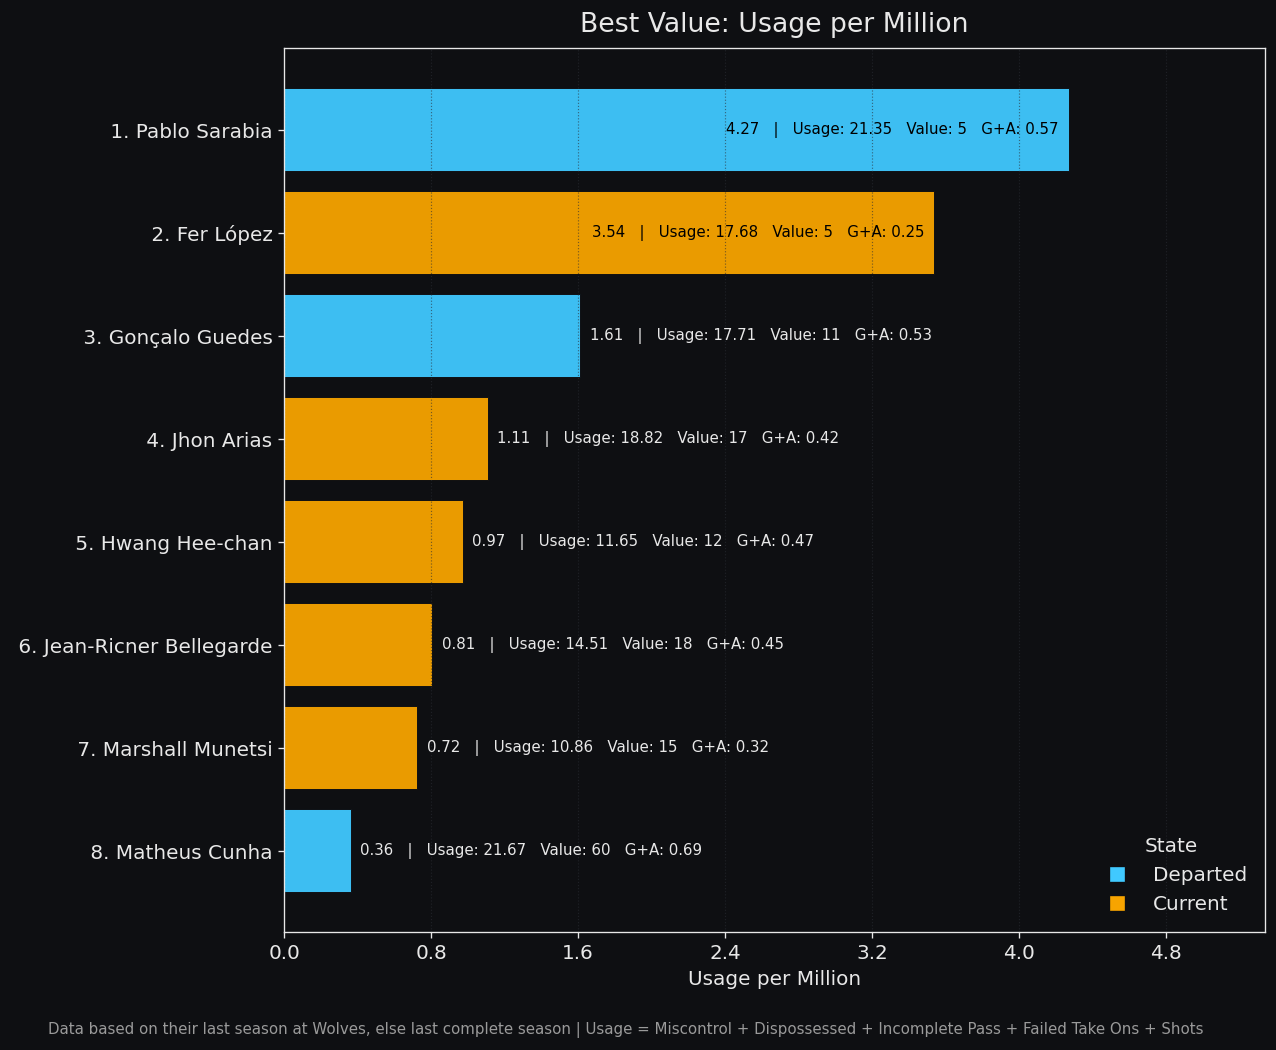

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

FILE  = "project3-2.xlsx"
SHEET = "FINAL"

LOGICAL_COLS = {
    "USAGE_COL":  ["usage rate", "usage", "usg", "usg%"],
    "VALUE_COL":  ["value", "tm value", "transfer value", "market value"],
    "STATE_COL":  ["state", "status", "roster state"],
    "PLAYER_COL": ["player", "player name", "name"],
    "GA_COL":     ["g+a", "ga", "goals + assists", "goals and assists"],
}

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
CURR_COLOR = "#f7a400"
DEPT_COLOR = "#40c9ff"

TITLE = "Best Value: Usage per Million"
FOOTNOTE = "Data based on their last season at Wolves, else last complete season | Usage = Miscontrol + Dispossessed + Incomplete Pass + Failed Take Ons + Shots"

#helpers
def _norm(s: str) -> str:
    s = str(s)
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())
    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]
    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]
    if required:
        raise KeyError(
            f"Could not resolve a column for candidates {candidates}. "
            f"Available columns: {list(df.columns)}"
        )
    return None

def fmt_float(x, nd=2):
    if x is None or not np.isfinite(x):
        return ""
    s = f"{x:.{nd}f}"
    s = s.rstrip("0").rstrip(".")
    return s

#load
if not os.path.exists(FILE):
    raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

df = pd.read_excel(FILE, sheet_name=SHEET)

resolved = {}
for logical, cands in LOGICAL_COLS.items():
    resolved[logical] = resolve_column(df, cands, required=(logical not in ["GA_COL"]))

USAGE_COL  = resolved["USAGE_COL"]
VALUE_COL  = resolved["VALUE_COL"]
STATE_COL  = resolved["STATE_COL"]
PLAYER_COL = resolved["PLAYER_COL"]
GA_COL     = resolved.get("GA_COL")

print("Column mapping:")
for k, v in resolved.items():
    if v is not None:
        print(f"  {k:<10} -> {v}")

#clean
work = df.copy()
work[USAGE_COL] = pd.to_numeric(work[USAGE_COL], errors="coerce")
work[VALUE_COL] = pd.to_numeric(work[VALUE_COL], errors="coerce")
if GA_COL:
    work[GA_COL] = pd.to_numeric(work[GA_COL], errors="coerce")

def _std_state(s):
    s = str(s).strip().lower()
    if s in {"current", "active", "on roster", "present"}:
        return "Current"
    if s in {"departed", "left", "sold", "loaned", "released", "former"}:
        return "Departed"
    return s.title()

work[STATE_COL] = work[STATE_COL].apply(_std_state)

work = work.dropna(subset=[USAGE_COL, VALUE_COL, PLAYER_COL, STATE_COL])
work = work[work[VALUE_COL] > 0].copy()

work["UsagePerValue"] = work[USAGE_COL] / work[VALUE_COL]
work["Rank"] = work["UsagePerValue"].rank(method="min", ascending=False).astype(int)
work = work.sort_values("UsagePerValue", ascending=True)

state_to_color = {"Current": CURR_COLOR, "Departed": DEPT_COLOR}
bar_colors = work[STATE_COL].map(state_to_color).fillna(FG_COLOR).values

#plot
plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": BG_COLOR,
    "axes.facecolor": BG_COLOR,
    "axes.edgecolor": FG_COLOR,
    "axes.labelcolor": FG_COLOR,
    "xtick.color": FG_COLOR,
    "ytick.color": FG_COLOR,
    "text.color": FG_COLOR,
    "grid.color": GRID_COLOR,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(12, 10), dpi=120)

y_pos = np.arange(len(work))
bars = ax.barh(
    y_pos, work["UsagePerValue"].values,
    color=bar_colors, edgecolor="#0e0f12", linewidth=0.6, alpha=0.95
)

player_labels = []
for _, r in work.iterrows():
    prefix = f"{r['Rank']:>2d}. "
    player_labels.append(prefix + str(r[PLAYER_COL]))
ax.set_yticks(y_pos, labels=player_labels)

ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.6)

ax.set_title(TITLE, fontsize=16, pad=10)
ax.set_xlabel("Usage per Million")

xmax = work["UsagePerValue"].max()
ax.set_xlim(0, xmax * 1.25 if np.isfinite(xmax) else 1.0)

plt.tight_layout(rect=[0.08, 0.08, 0.98, 0.93])
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

ax_bbox_disp = ax.get_window_extent(renderer)
x0, x1 = ax.get_xlim()
pad = (x1 - x0) * 0.01

for bar, (_, r) in zip(bars, work.iterrows()):
    xval = bar.get_width()
    yval = bar.get_y() + bar.get_height() / 2.0

    usage_str  = fmt_float(r[USAGE_COL])
    value_str  = fmt_float(r[VALUE_COL])
    metric_str = fmt_float(r["UsagePerValue"])
    if GA_COL and pd.notna(r.get(GA_COL)):
        ga_str = fmt_float(r[GA_COL])
        text = f"{metric_str}   |   Usage: {usage_str}   Value: {value_str}   G+A: {ga_str}"
    else:
        text = f"{metric_str}   |   Usage: {usage_str}   Value: {value_str}"

    txt = ax.text(xval + pad, yval, text,
                  va="center", ha="left", fontsize=9, color=FG_COLOR,
                  zorder=5, clip_on=False)

    fig.canvas.draw()
    txt_bbox = txt.get_window_extent(renderer)

    if txt_bbox.x1 > ax_bbox_disp.x1:
        txt.set_x(xval - pad)
        txt.set_ha("right")
        txt.set_color("black")
        txt.set_clip_on(True)
        fig.canvas.draw()
        txt_bbox = txt.get_window_extent(renderer)

        if txt_bbox.x1 > ax_bbox_disp.x1:
            extra = (x1 - x0) * 0.002
            txt.set_x(xval - pad - extra)
            fig.canvas.draw()

#legend
state_labels_present = list(dict.fromkeys(work[STATE_COL].tolist()))
state_handles = []
for label in state_labels_present:
    color = state_to_color.get(label, FG_COLOR)
    state_handles.append(
        Line2D([0], [0], marker="s", color="none",
               markerfacecolor=color, markeredgecolor="#0e0f12",
               markeredgewidth=0.8, markersize=10, label=label)
    )

if state_handles:
    ax.legend(handles=state_handles, title="State",
              loc="lower right", frameon=False)

fig.text(0.12, 0.06, FOOTNOTE, color="#9a9a9a", fontsize=9)
plt.show()
